# Random Forest Analysis of German Breast Cancer Study Group 2

This example is an overview of how to perform a stacked survival analysis
using the two available interfaces of survstack as well as a comparison
of the result to a conventional survival analysis using 
[scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score
import sksurv.datasets

## Load data

The scikit-survival package provides multiple survival datasets including the 
German Breast Cancer Study Group 2 dataset which contains 686 samples and 8 
features. None numerical features are converted using the scikit-learn
preprocessing functions.

In [4]:
X, y = sksurv.datasets.load_gbsg2()
event_field, time_field = y.dtype.names

In [5]:
X_enc = X[['age','estrec','pnodes','progrec','tsize']].copy()
X_enc['tgrade'] = \
    OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(X[["tgrade"]])
X_enc['horTh'] = \
    OrdinalEncoder(categories=[["no", "yes"]]).fit_transform(X[["horTh"]])
X_enc['menostat'] = \
    OrdinalEncoder(categories=[["Pre", "Post"]]).fit_transform(X[["menostat"]])
X_enc.head()

,age,estrec,pnodes,progrec,tsize,tgrade,horTh,menostat
0,70.0,66.0,3.0,48.0,21.0,1.0,0.0,1.0
1,56.0,77.0,7.0,61.0,12.0,1.0,1.0,1.0
2,58.0,271.0,9.0,52.0,35.0,1.0,1.0,1.0
3,59.0,29.0,4.0,60.0,17.0,1.0,1.0,1.0
4,73.0,65.0,1.0,26.0,35.0,1.0,0.0,1.0


Split dataset into training and testing sets

In [6]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X_enc.values, y, 
                                                    test_size=0.25, 
                                                    stratify=y[event_field], 
                                                    random_state=random_state)

## Class Interface
The recommended interface for this package is the SurvivalStacker class. The will determine and save
the time points on which the survial analysis is conducted.

In [7]:
from survstack import SurvivalStacker
ss = SurvivalStacker()

The training dataset it transformed into stacked survival format. In 
doing so, an additional column is added to X for each observed event time-point 
and rows a duplicated with respect to the number of survivors at each time-point. 

In [8]:
X_oo_train, y_oo_train = ss.fit_transform(X_train, y_train)


The test set is modified differently. In order to calculate the hazard across
all time-points, a duplicate sample for each time-point must be created.
To do so, simply do not provide `y` to the `.transform()` function.
However, to maintain consitancy, a None value is returned as the second
values of the tuple and can be discarded. 

In [9]:
X_oo_test, _ = ss.transform(X_test)

Train the RandomForestClassifier on the stacked surival data

In [10]:
%%time
oo_rfc = RandomForestClassifier(
    n_estimators=1000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=random_state)
_ = oo_rfc.fit(X_oo_train, y_oo_train)

CPU times: user 3min 18s, sys: 1.52 s, total: 3min 19s
Wall time: 5.99 s


Predict the class probabilities for the test data and extract
the probaility of an event (class 1). Convert this to a cummulative
hazard function.

In [11]:
oo_test_estimates = oo_rfc.predict_proba(X_oo_test)[:,1]
oo_test_chf = ss.cumulative_hazard_function(oo_test_estimates)

We examine the predictive power of the models using the cumulative/dynamic
AUC method provided in scikit-survival. However, this function require that
all examined time-points are contained within the observations of the test
set, so we may have to first filter the results.

In [12]:
def filter_times_on_test(survival_test, estimate, times):
    event_field, time_field = survival_test.dtype.names
    valid_idx = np.where((times > survival_test[time_field].min())&
                         (times < survival_test[time_field].max()))[0]
    valid_times = times[valid_idx]
    valid_estimate = estimate[:, valid_idx]
    return valid_times, valid_estimate

In [13]:
oo_filt_times, oo_filt_chf = filter_times_on_test(y_test, oo_test_chf, ss.times)

Calculate the cumulative/dynamic AUC

In [14]:
oo_cdauc = cumulative_dynamic_auc(survival_train=y_train, 
                                  survival_test=y_test, 
                                  estimate=oo_filt_chf, 
                                  times=oo_filt_times)[0]

/opt/conda/lib/python3.10/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Plot the results. We get a mean AUC of 0.757.

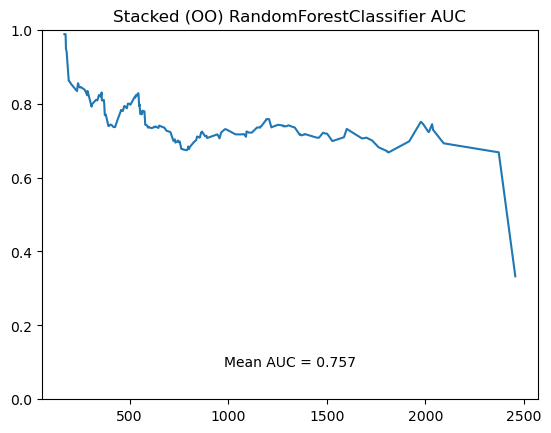

In [15]:
ax = sns.lineplot(y=oo_cdauc, x=oo_filt_times)
_ = ax.set(ylim=(0, 1))
_ = ax.set_title(f"Stacked (OO) RandomForestClassifier AUC")
x_pos = np.mean(ax.get_xlim())
_ = ax.text(x_pos, 0.1, f"Mean AUC = {np.nanmean(oo_cdauc):0.3f}", 
            ha = "center", va = "center")

## Functional Approach
Alternatively, the stacked survival analysis can be performed using
the functional interface.

In [16]:
import survstack.functional as ssf

Determine the unique event observation times of the training set. 

In [17]:
event_times = np.unique(y_train[y_train['cens']]['time'])

Generate the stacked survival training and testing datasets

In [18]:
X_fun_train, y_fun_train = ssf.stack_timepoints(X_train, y_train, event_times)
X_fun_test = ssf.stack_eval(X_test, event_times)

Train the model and calculate the cumulative hazard function.

In [19]:
%%time
f_rfc = RandomForestClassifier(
    n_estimators=1000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=random_state)
_ = f_rfc.fit(X_fun_train, y_fun_train)

CPU times: user 3min 17s, sys: 2.09 s, total: 3min 19s
Wall time: 6.02 s


In [20]:
f_test_estimates = f_rfc.predict_proba(X_fun_test)[:,1]
f_test_chf = ssf.cumulative_hazard_function(f_test_estimates, event_times)

Calculate the cumulative/dynamic AUC. As expected, we again observe a
mean AUC of 0.757 and an identical curve.

In [21]:
f_filt_times, f_filt_chf = filter_times_on_test(y_test, f_test_chf, event_times)
f_cdauc = cumulative_dynamic_auc(survival_train=y_train, survival_test=y_test, estimate=f_filt_chf, times=f_filt_times)[0]

/opt/conda/lib/python3.10/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


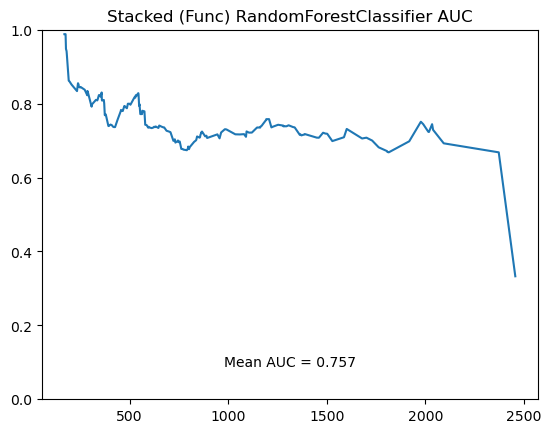

In [22]:
ax = sns.lineplot(y=f_cdauc, x=f_filt_times)
_ = ax.set(ylim=(0, 1))
_ = ax.set_title(f"Stacked (Func) RandomForestClassifier AUC")
x_pos = np.mean(ax.get_xlim())
_ = ax.text(x_pos, 0.1, f"Mean AUC = {np.nanmean(f_cdauc):0.3f}", ha = "center", va = "center")

## scikit-survival Random Survival Forest
For comparison, we can do the same analysis on the original data
using a random survival forest as provided by scikit-survival. Briefly,
we train the RandomSurvivalForest on the training data, and predict the
cumulative hazard function of the test data. Finally, we calculate the
cumulative/dynamic AUC of the prediction.

In [23]:
from sksurv.ensemble import RandomSurvivalForest

In [24]:
%%time
rsf = RandomSurvivalForest(
    n_estimators=1000, 
    n_jobs=-1, 
    random_state=random_state
)
_ = rsf.fit(X_train, y_train)

CPU times: user 53.5 s, sys: 44 s, total: 1min 37s
Wall time: 25.7 s


In [25]:
rsf_test_chf = rsf.predict_cumulative_hazard_function(X_test, return_array=True)

In [26]:
rsf_filt_times, rsf_filt_chf = filter_times_on_test(y_test, rsf_test_chf, event_times)
rsf_cdauc = cumulative_dynamic_auc(survival_train=y_train, survival_test=y_test, estimate=rsf_filt_chf, times=rsf_filt_times)[0]

/opt/conda/lib/python3.10/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Plotting the results we see a very famililar curve and a slightly better mean AUC of 0.781.

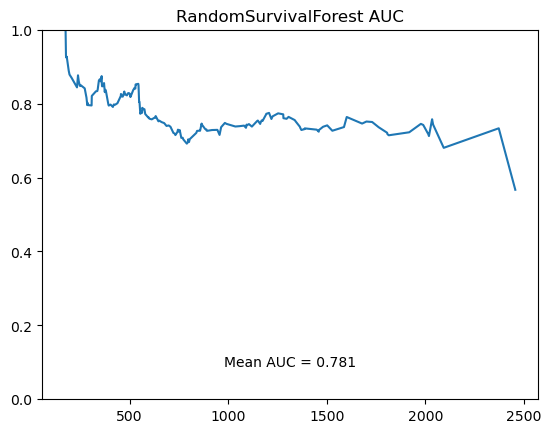

In [27]:
ax = sns.lineplot(y=rsf_cdauc, x=rsf_filt_times)
_ = ax.set(ylim=(0, 1))
_ = ax.set_title(f"RandomSurvivalForest AUC")
x_pos = np.mean(ax.get_xlim())
_ = ax.text(x_pos, 0.1, f"Mean AUC = {np.nanmean(rsf_cdauc):0.3f}", ha = "center", va = "center")